# Random Forest Classification on Breast Cancer Dataset

This notebook demonstrates the implementation of Random Forest classifier on the breast cancer dataset from scikit-learn. We'll explore the data, train the model, evaluate its performance, and visualize the results.

## Overview
- **Dataset**: Breast Cancer Wisconsin (Diagnostic) Dataset
- **Problem Type**: Binary Classification (Malignant vs Benign)
- **Algorithm**: Random Forest Classifier
- **Features**: 30 numerical features computed from breast mass images

## Import Required Libraries

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

## Load and Explore the Dataset

In [4]:
# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print("🔹 Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Features: {len(data.feature_names)}")
print(f"Classes: {data.target_names}")
print(f"Target distribution:\n{pd.Series(y).value_counts()}")

# Display first few rows
print("\n🔹 First 5 rows:")
df.head()

🔹 Dataset Information:
Shape: (569, 31)
Features: 30
Classes: ['malignant' 'benign']
Target distribution:
1    357
0    212
Name: count, dtype: int64

🔹 First 5 rows:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
# Dataset description and statistics
print("🔹 Dataset Description:")
print(data.DESCR[:500] + "...")

print("\n🔹 Basic Statistics:")
print(df.describe())

🔹 Dataset Description:
.. _breast_cancer_dataset:

Breast cancer Wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (...

🔹 Basic Statistics:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000 

## Data Visualization

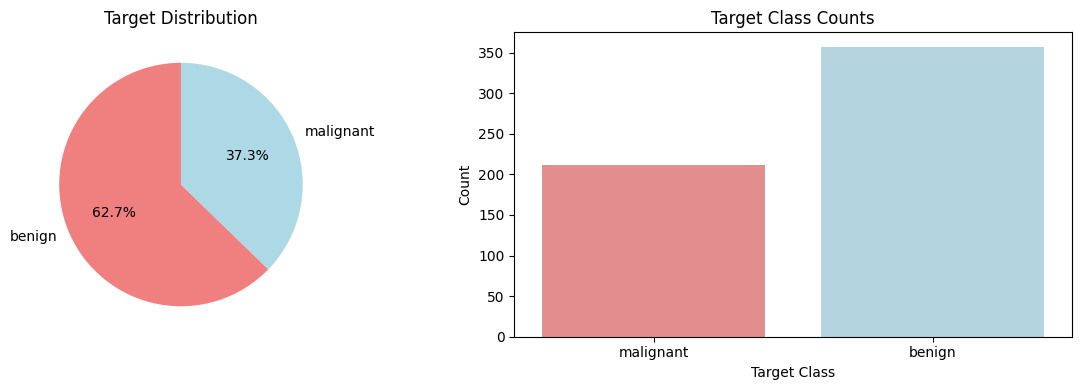

In [6]:
# Target distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
target_counts = pd.Series(y).value_counts()
target_labels = [data.target_names[i] for i in target_counts.index]
colors = ['lightcoral', 'lightblue']
plt.pie(target_counts.values, labels=target_labels, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Target Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x=y, palette=colors)
plt.xticks([0, 1], data.target_names)
plt.title('Target Class Counts')
plt.xlabel('Target Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

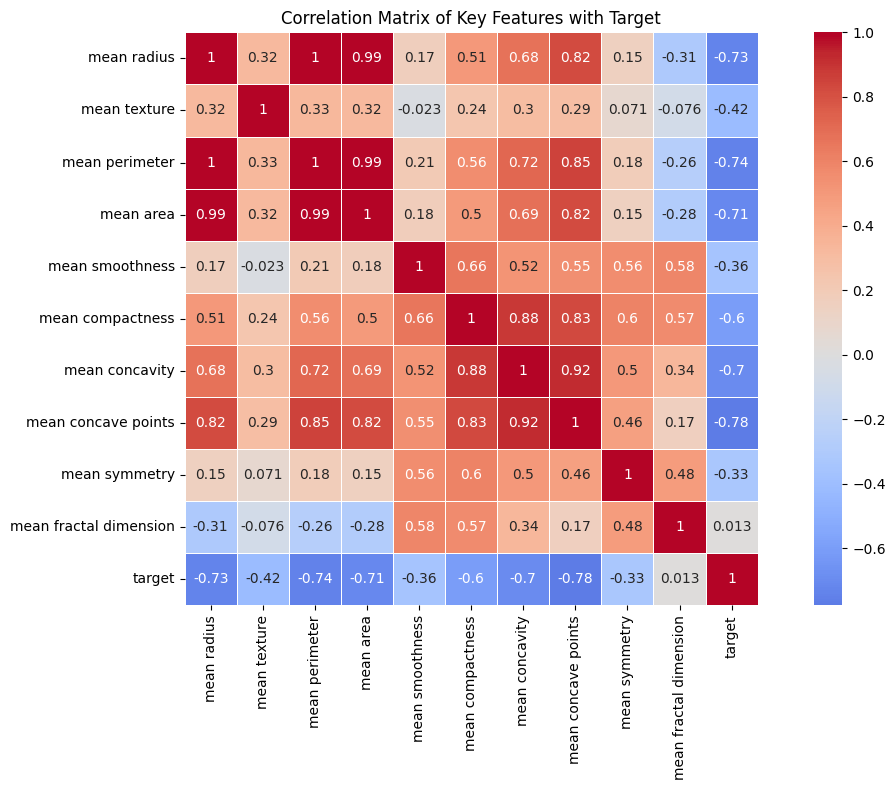

In [7]:
# Feature analysis - correlation heatmap of key features
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 
                'mean smoothness', 'mean compactness', 'mean concavity', 
                'mean concave points', 'mean symmetry', 'mean fractal dimension']

plt.figure(figsize=(12, 8))
correlation_matrix = df[key_features + ['target']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Key Features with Target')
plt.tight_layout()
plt.show()

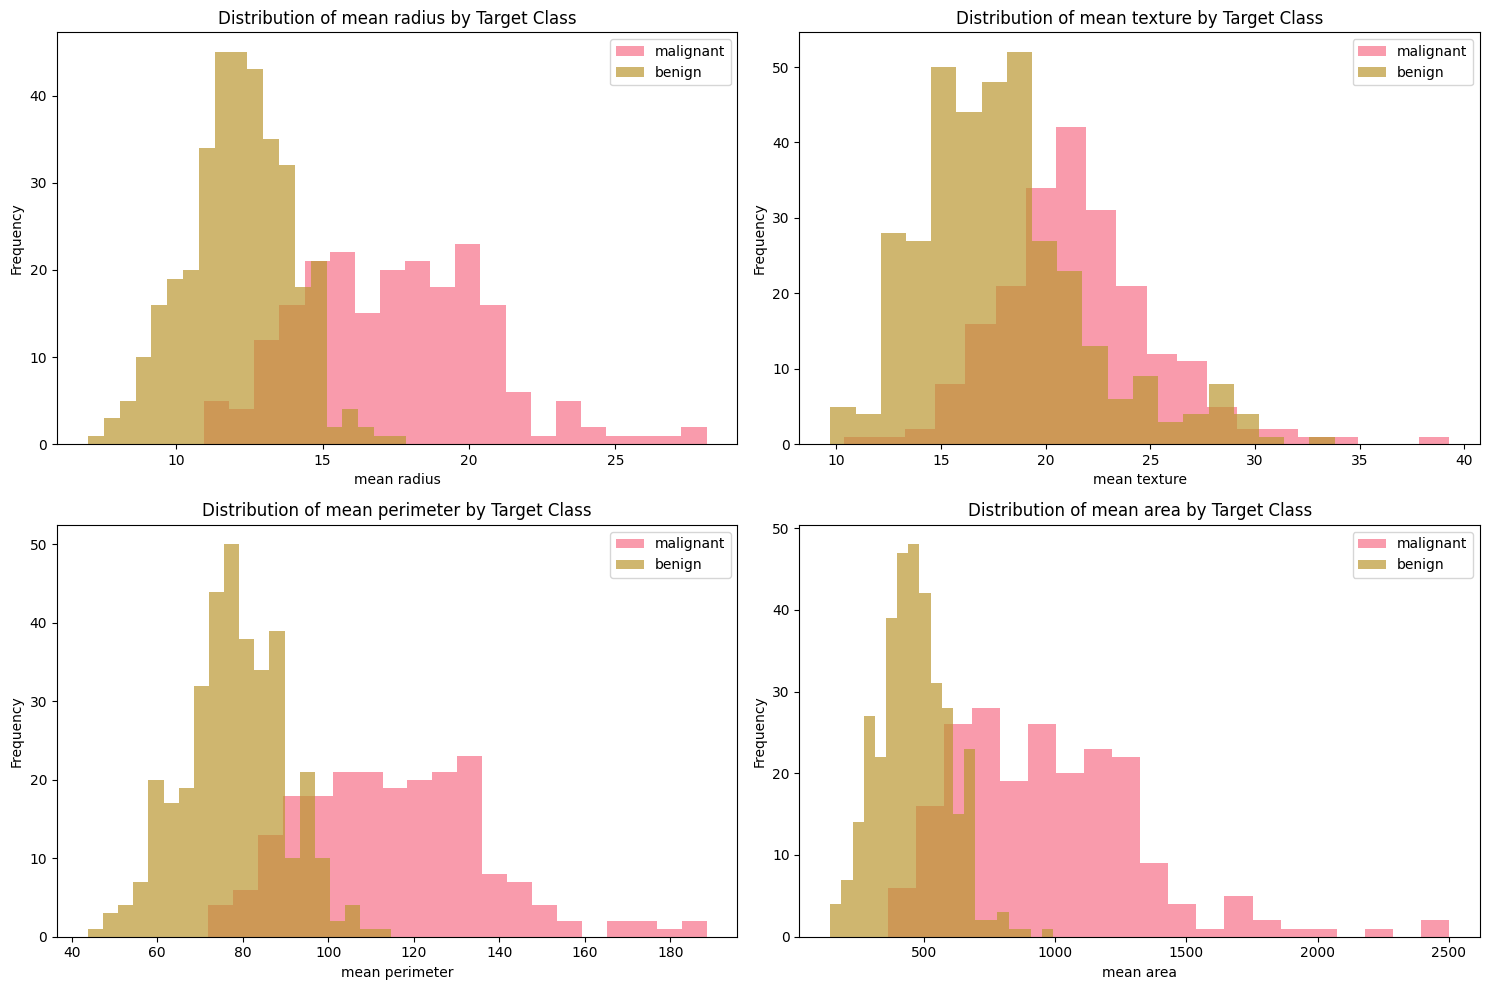

In [8]:
# Distribution of key features by target class
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
features_to_plot = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']

for i, feature in enumerate(features_to_plot):
    ax = axes[i//2, i%2]
    
    # Plot distributions for each class
    for target_val, target_name in enumerate(data.target_names):
        feature_data = df[df['target'] == target_val][feature]
        ax.hist(feature_data, alpha=0.7, label=target_name, bins=20)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {feature} by Target Class')
    ax.legend()

plt.tight_layout()
plt.show()

## Data Preprocessing and Model Training

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=y)

print("🔹 Data Split:")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Testing target distribution: {np.bincount(y_test)}")

🔹 Data Split:
Training set: (398, 30)
Testing set: (171, 30)
Training target distribution: [148 250]
Testing target distribution: [ 64 107]


In [10]:
# Create and train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

print("🔹 Random Forest Model Trained Successfully!")
print(f"Number of trees: {rf_classifier.n_estimators}")
print(f"Number of features: {rf_classifier.n_features_in_}")
print(f"Feature names: {len(data.feature_names)} features")

🔹 Random Forest Model Trained Successfully!
Number of trees: 100
Number of features: 30
Feature names: 30 features


## Model Evaluation

In [11]:
# Make predictions
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)

# Calculate accuracy scores
train_accuracy = rf_classifier.score(X_train, y_train)
test_accuracy = rf_classifier.score(X_test, y_test)

print("🔹 Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba[:, 1]):.4f}")

# Classification report
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

🔹 Model Performance:
Training Accuracy: 1.0000
Testing Accuracy: 0.9357
ROC AUC Score: 0.9913

🔹 Classification Report:
              precision    recall  f1-score   support

   malignant       0.92      0.91      0.91        64
      benign       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



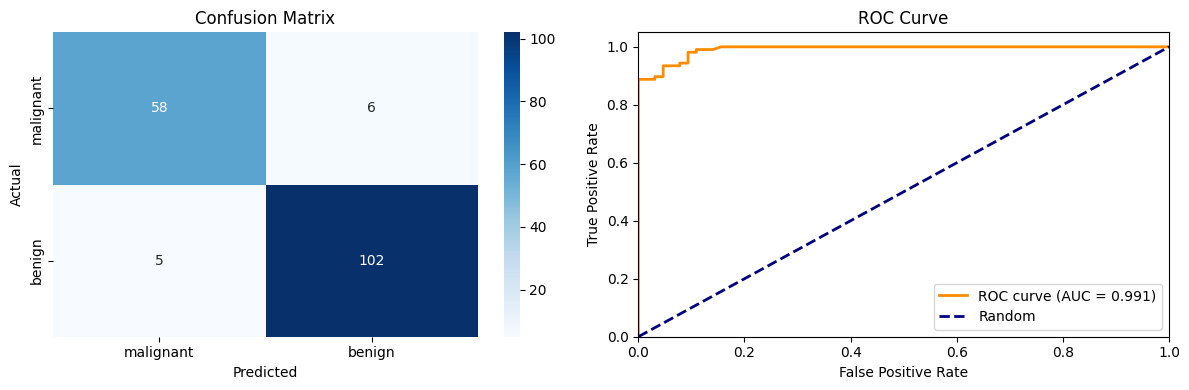

In [12]:
# Confusion Matrix
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=data.target_names, yticklabels=data.target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Feature Importance Analysis

🔹 Top 10 Most Important Features:
                 feature  importance
27  worst concave points    0.158955
23            worst area    0.146962
22       worst perimeter    0.085793
20          worst radius    0.078952
0            mean radius    0.077714
2         mean perimeter    0.074234
7    mean concave points    0.065869
6         mean concavity    0.054281
3              mean area    0.041657
26       worst concavity    0.031362


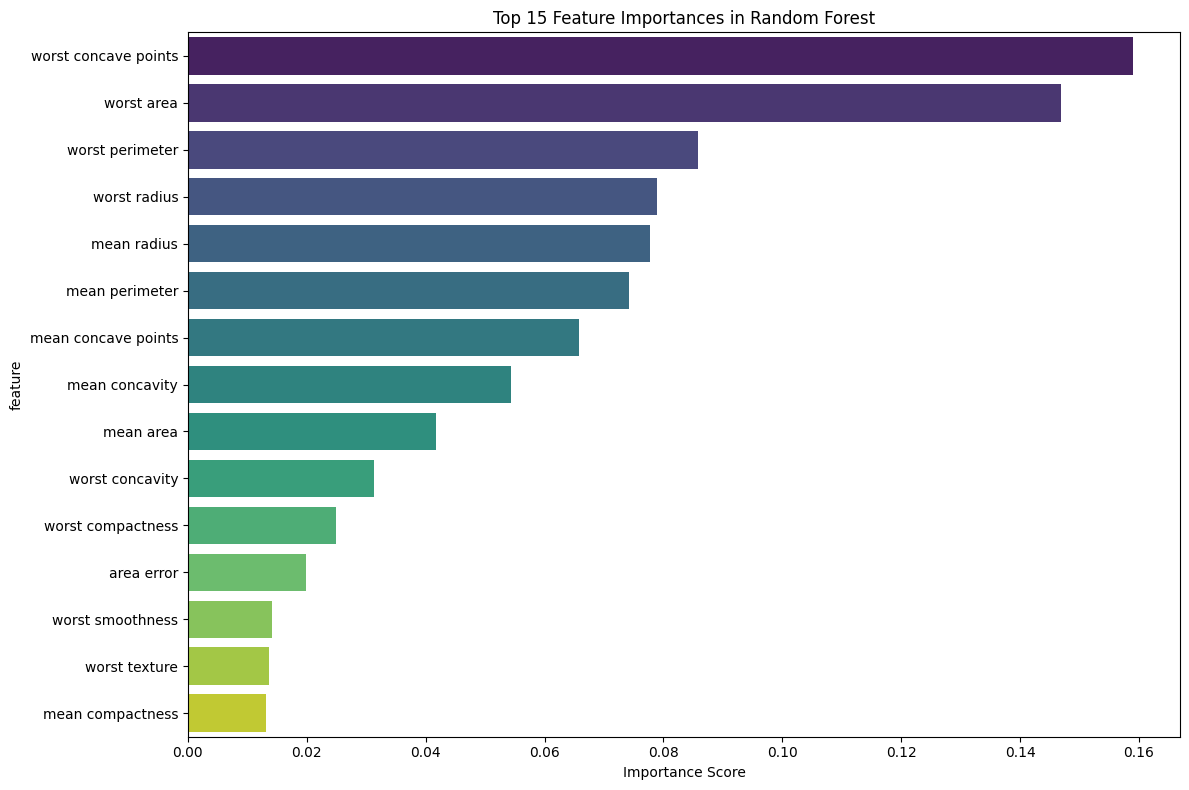

In [13]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': data.feature_names,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("🔹 Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 15 Feature Importances in Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [14]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("🔹 Starting Grid Search for hyperparameter tuning...")
print("This may take a few minutes...")

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\n🔹 Best Parameters: {grid_search.best_params_}")
print(f"🔹 Best Cross-validation Score: {grid_search.best_score_:.4f}")

🔹 Starting Grid Search for hyperparameter tuning...
This may take a few minutes...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

🔹 Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
🔹 Best Cross-validation Score: 0.9725


In [15]:
# Evaluate the best model
best_rf = grid_search.best_estimator_
best_y_pred = best_rf.predict(X_test)
best_y_pred_proba = best_rf.predict_proba(X_test)

print("🔹 Optimized Model Performance:")
print(f"Training Accuracy: {best_rf.score(X_train, y_train):.4f}")
print(f"Testing Accuracy: {best_rf.score(X_test, y_test):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, best_y_pred_proba[:, 1]):.4f}")

print("\n🔹 Optimized Classification Report:")
print(classification_report(y_test, best_y_pred, target_names=data.target_names))

🔹 Optimized Model Performance:
Training Accuracy: 1.0000
Testing Accuracy: 0.9357
ROC AUC Score: 0.9913

🔹 Optimized Classification Report:
              precision    recall  f1-score   support

   malignant       0.92      0.91      0.91        64
      benign       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



## Model Comparison and Cross-Validation

🔹 Cross-Validation Results:
CV Scores: [0.98245614 0.89473684 0.94736842 0.94736842 1.         0.98245614
 0.94736842 0.98245614 0.94736842 1.        ]
Mean CV Score: 0.9632 (+/- 0.0617)


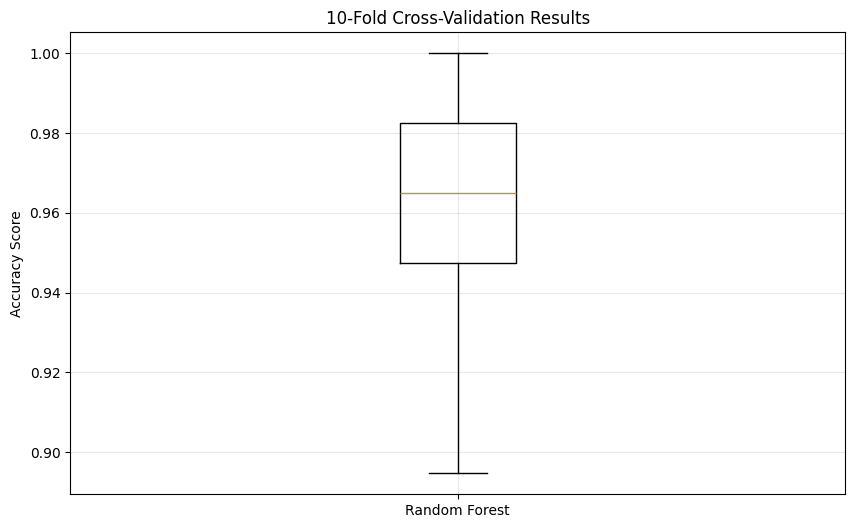

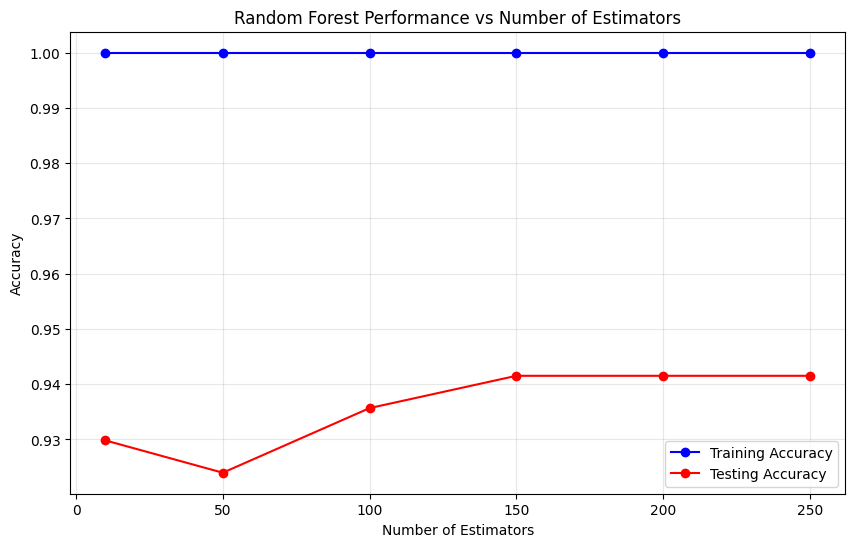

In [16]:
# Cross-validation analysis
cv_scores = cross_val_score(best_rf, X, y, cv=10, scoring='accuracy')

print("🔹 Cross-Validation Results:")
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Plot cross-validation scores
plt.figure(figsize=(10, 6))
plt.boxplot(cv_scores, labels=['Random Forest'])
plt.ylabel('Accuracy Score')
plt.title('10-Fold Cross-Validation Results')
plt.grid(True, alpha=0.3)
plt.show()

# Compare different number of estimators
n_estimators_range = [10, 50, 100, 150, 200, 250]
train_scores = []
test_scores = []

for n_est in n_estimators_range:
    rf_temp = RandomForestClassifier(n_estimators=n_est, random_state=42)
    rf_temp.fit(X_train, y_train)
    train_scores.append(rf_temp.score(X_train, y_train))
    test_scores.append(rf_temp.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, 'o-', label='Training Accuracy', color='blue')
plt.plot(n_estimators_range, test_scores, 'o-', label='Testing Accuracy', color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance vs Number of Estimators')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Decision Tree Visualization

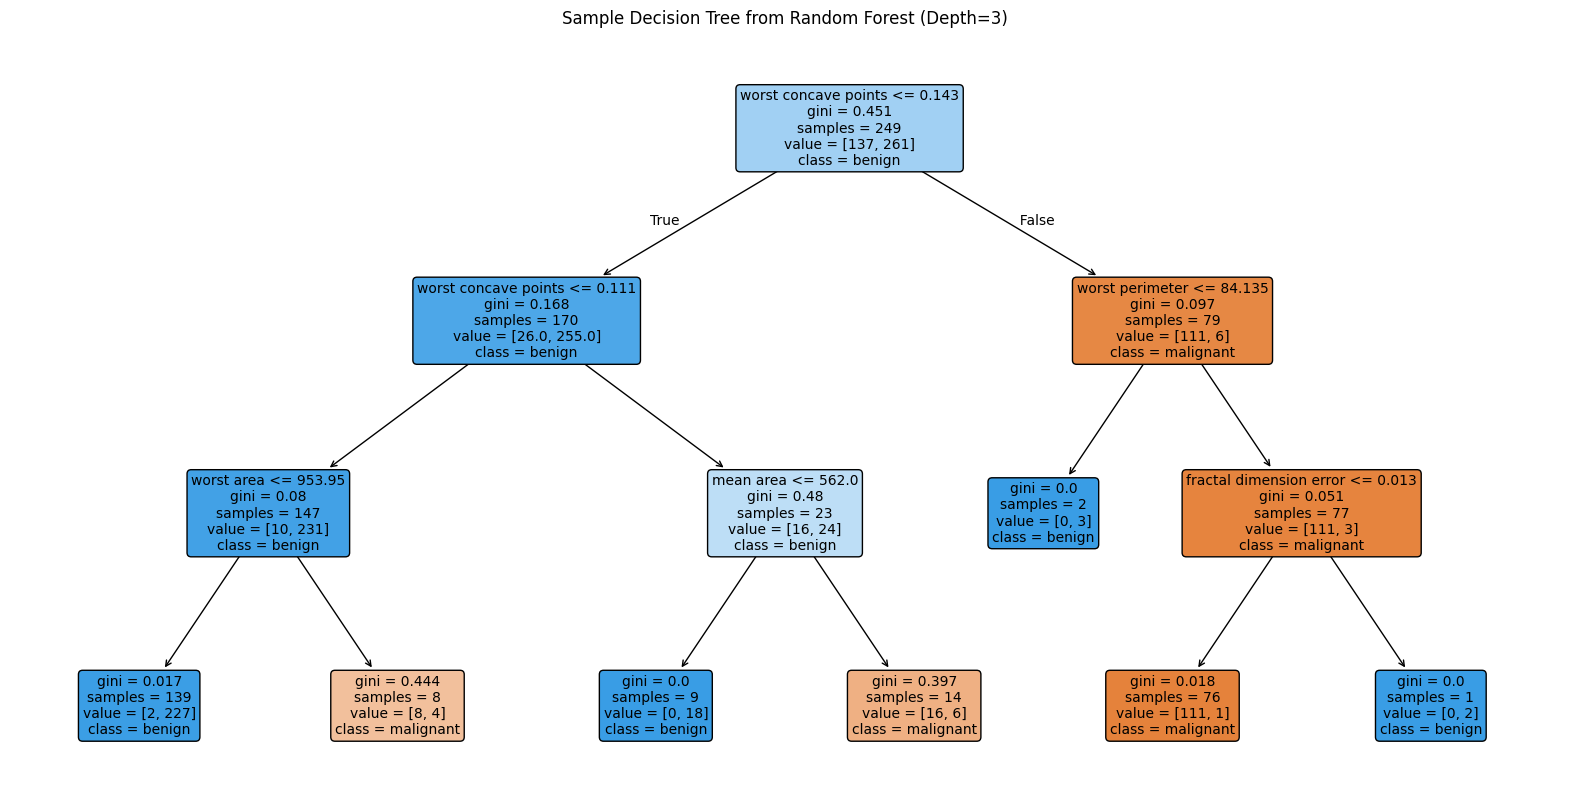

🔹 Note: This shows just one tree from the forest with limited depth for visualization purposes.
🔹 The actual Random Forest contains many deeper trees for better performance.


In [17]:
# Visualize one of the decision trees (limited depth for readability)
from sklearn.tree import plot_tree

# Create a smaller tree for visualization
small_rf = RandomForestClassifier(n_estimators=1, max_depth=3, random_state=42)
small_rf.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(small_rf.estimators_[0], 
          feature_names=data.feature_names,
          class_names=data.target_names,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Sample Decision Tree from Random Forest (Depth=3)')
plt.show()

print("🔹 Note: This shows just one tree from the forest with limited depth for visualization purposes.")
print("🔹 The actual Random Forest contains many deeper trees for better performance.")

## Summary and Conclusions

In [18]:
# Final model summary
print("🔹 RANDOM FOREST BREAST CANCER CLASSIFICATION - SUMMARY")
print("=" * 60)
print(f"📊 Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"🎯 Problem: Binary classification (Malignant vs Benign)")
print(f"🌳 Model: Random Forest with {best_rf.n_estimators} trees")
print(f"📈 Best Test Accuracy: {best_rf.score(X_test, y_test):.4f}")
print(f"📈 ROC AUC Score: {roc_auc_score(y_test, best_y_pred_proba[:, 1]):.4f}")
print(f"📈 Cross-validation Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("\n🏆 Key Findings:")
print("• Random Forest achieved excellent performance on breast cancer classification")
print("• The model shows high accuracy and good generalization")
print("• Feature importance reveals the most discriminative characteristics")
print("• Cross-validation confirms model robustness")
print("\n💡 Most Important Features:")
for i, (feature, importance) in enumerate(feature_importance.head(5).values):
    print(f"  {i+1}. {feature}: {importance:.4f}")
print("=" * 60)

🔹 RANDOM FOREST BREAST CANCER CLASSIFICATION - SUMMARY
📊 Dataset: 569 samples, 30 features
🎯 Problem: Binary classification (Malignant vs Benign)
🌳 Model: Random Forest with 100 trees
📈 Best Test Accuracy: 0.9357
📈 ROC AUC Score: 0.9913
📈 Cross-validation Score: 0.9632 ± 0.0308

🏆 Key Findings:
• Random Forest achieved excellent performance on breast cancer classification
• The model shows high accuracy and good generalization
• Feature importance reveals the most discriminative characteristics
• Cross-validation confirms model robustness

💡 Most Important Features:
  1. worst concave points: 0.1590
  2. worst area: 0.1470
  3. worst perimeter: 0.0858
  4. worst radius: 0.0790
  5. mean radius: 0.0777
